In [1]:
from pysb import *
from pysb.util import alias_model_components
from pysb.macros import *




# =======================================
# =======================================
# define variables and initial conditions
# =======================================
# =======================================
def ini_variables_monomers():
    # cells in the model
    Monomer('otherCell')
    Monomer('MSC', ['PTH_receptor'])
    Monomer('PreOsteoblast', ['PTH_receptor'])
    Monomer('Osteoblast')
    Monomer('Osteocyte')
    Monomer('Myeloid',['RANKL_receptor', 'cell_docl', 'cell_docr'])
    Monomer('Osteoclast')
    Monomer('HSC')
    Monomer('otherCells')    

    # proteins
    Monomer('PTH_PTHrP', ['binding_domain'])
    Monomer('RANKL',['binding_domain'])    
    alias_model_components()

    
def ini_variables():
    # initial conditions
    Parameter('MSC_0', 1.0)
    Parameter('HSC_0', 1.0)
    Parameter('PTH_PTHrP_0', 100.0)
    
    # Initial component
    Initial(MSC(PTH_receptor=None), MSC_0)
    Initial(HSC, HSC_0)
    Initial(PTH_PTHrP(binding_domain=None), PTH_PTHrP_0)
    alias_model_components()


def rate_parameters():
    Parameter('r1', 1.0) # MSC differentiation to other cells
    Parameter('r2', 1.0) # MSC death rate
    Parameter('r3', 1.0) # MSC proliferation rate
    Parameter('r4_kf',1.0) # PTH/PTHrP docks at MSC
    Parameter('r4_kr',1.0) # PTH/PTHrP breaks from MSC
    Parameter('r5', 1.0) # MSC differentiation to PreOsteoblasts
    Parameter('r6_kf',1.0) # PTH/PTHrP docks at PreObl 
    Parameter('r6_kr',1.0) # PTH/PTHrP breaks from PreObl
    Parameter('r7', 1.0) # PreObl differentiation to Osteoblasts
    Parameter('r8', 1.0) # Osteoblast differnetiation to Osteocyte 
    Parameter('r9',1.0) # HSC proliferation rate    
    Parameter('r10', 1.0) # PreObl-RANKL expression rate
    Parameter('r11', 1.0) # use Ocl as catalyst to stimulate more Obl production in PreObl (feedback)
    Parameter('r12_kf', 1.0) # RANKL docks at Myeloid
    Parameter('r12_kr', 1.0) # RANKL breaks from Myeloid
    Parameter('r13_kf', 1.0) # Myeloids form chain links
    Parameter('r13_kr', 1.0) # Myeloid chain links break up again
    Parameter('r13_ocl', 1.0) # Myeloid chain of size 3-10 form Osteoclast
    Parameter('r14', 1.0) # Osteoclast death rate 
    Parameter('r15',1.0)
    Parameter('r16', 1.0)
    Parameter('r17', 1.0)
    alias_model_components()


In [2]:
# =============================
# =============================
# define top line of the graph
# =============================
# =============================


def Mysenchomal_SC_to_Osteocytes():
    # r1 MSC differentiation to other cells independent of PTH binding status
    Rule('differentiation_MSC_others',
         MSC() >> otherCell, r1)

    # r2/() MSC die independent of PTH binding status
    Rule('celldeath_Mesenchymal_SC',
         MSC() >> None, r2)

    # r3/() MSC proliferation independent of PTH binding status
    Rule('proliferation_Mesenchymal_SC',
         MSC() >> MSC() + MSC(PTH_receptor=None),r3)

    # r4/(0-1) binding/unbinding with PTH/PTHrP
    bind(MSC,'PTH_receptor',PTH_PTHrP,'binding_domain',[r4_kf, r4_kr])

    # r5/(1) differentiation to PreOsteoblasts if PTH/PTHrP is present
    Rule('diff_MSC_PreObl',
         MSC(PTH_receptor=1)%PTH_PTHrP(binding_domain=1) 
         >> PreOsteoblast(PTH_receptor=1)%PTH_PTHrP(binding_domain=1),r5)

    # r6/(0-1) binding/unbinding w PTH/PTHrP 
    bind(PreOsteoblast,'PTH_receptor',PTH_PTHrP,'binding_domain',[r6_kf, r6_kr])

    # r7/(0) differentiation to Osteoblasts
    Rule('diff_PreObl_Obl',
         PreOsteoblast(PTH_receptor=None) >> Osteoblast(),r7)

    # r10 express RANKL 
    Rule('express_RANKL',
         PreOsteoblast(PTH_receptor=1)%PTH_PTHrP(binding_domain=1) >> PreOsteoblast(PTH_receptor=1)%PTH_PTHrP(binding_domain=1) + RANKL(binding_domain=None),r10)

    # r8 differentiation to Osteocytes 
    Rule('diff_Obl_Ocy',
         Osteoblast() >> Osteocyte(),r8)

    
    
# ==============================================================
# ==============================================================
# lower part of the graph (includes generation of myeloid chain)
# ==============================================================
# ==============================================================


def myeloid_chain(n=10):
    # =========building blocks for the myeloid chain=========================================

    # =================================================
    # =======create the reactions for the rules========
    # =================================================

    # note that the RANKL_receptor=ANY forces the RANKL_receptor to be bound to something
    # since the only rule that uses the RANKL_receptor is the rule that binds Myeloid to
    # RANKL, ANY will always be bound to a RANKL -> bond number has not be specified

    # create a Myeloid-Rankl reaction
    #==========================================================================================
    myeloid_rankl = {
        0: Myeloid(RANKL_receptor=ANY,cell_docl=None,cell_docr=None)
    }


    # create the left-most reaction of the form M(i,0,1)%R(i)
    # ================================================================================================
    leftmost_reaction = {
        0: Myeloid(RANKL_receptor=ANY,cell_docl=None,cell_docr=1)
    }


    # create inner reaction chain-links of the form M(i,1,2)%R(i)%M(l,2,3)%R(l)%...%M(o,n-3,n-2)%R(o)
    # =================================================================================================
    inner_links = {
        0: Myeloid(RANKL_receptor=ANY,cell_docl=1,cell_docr=2)
    }

    for i in range(1,n-2):
        inner_links[i] = inner_links[i-1]%Myeloid(RANKL_receptor=ANY,cell_docl=i+1,cell_docr=i+2)


    # create an array of all the dictionaries for the right-most reaction of the form M(i,n-1,0)%R(i)
    # ================================================================================================
    # compute, how many entries for the dictionaries are needed:
    # n=3: M(32,2,0)
    # n=4: M(42,2,0) M(43,3,0)
    # n=5: M(52,2,0) M(53,3,0)  M(54,4,0)
    # n=6: M(62,2,0) M(63,3,0)  M(64,4,0) M(65,5,0)
    rightmost_reactions = []
    for i in range(1,n):
        rightmost_reactions.append(Myeloid(RANKL_receptor=ANY,cell_docl=i,cell_docr=None))


    # concatinate the reactions
    # =================================================
    reaction_chain = {
        0: leftmost_reaction[0]%rightmost_reactions[0]
    }
    for i in range(1,n-1):
        reaction_chain[i] = leftmost_reaction[0]%inner_links[i-1]%rightmost_reactions[i]

        

    # =========PYSB REACTIONS=========================================

    # HSC proliferation
    # r9
    Rule('proliferation_HSC',
         HSC() >> HSC() + HSC(),r9)


    # HSC differentiation into Myeloids
    # r15
    Rule('diff_HSC_Ml',
         HSC() >> Myeloid(RANKL_receptor=None, cell_docl=None, cell_docr=None),r15)

    # HSC differentiation to other cells
    # r16
    Rule('differentiation_HSC_others',
         HSC() >> otherCells,r16)

    # HSC die
    # r17
    Rule('celldeath_HSC',
         HSC() >> None,r17)


    # bind RANKL to empty Myeloids
    # r12/(0-1) binding/unbinding w RANKL, keep the cell-docking stations empty for now
    Rule('bind_RANKL_to_Myeloid',
         Myeloid(RANKL_receptor=None, cell_docl=None,cell_docr=None)+RANKL(binding_domain=None) |
         Myeloid(RANKL_receptor=1, cell_docl=None, cell_docr=None) % RANKL(binding_domain=1),
         r12_kf,r12_kr)


    # bind two Myeloids
    Rule('bind_two_Myeloids',
         Myeloid(RANKL_receptor=ANY,cell_docl=None,cell_docr=None) +
         Myeloid(RANKL_receptor=ANY,cell_docl=None,cell_docr=None) |
         reaction_chain[0],
         r13_kf,r13_kr)


    # bind three - n Myeloids & create Osteoclasts
    for i in range(1,n-1):
            Rule('bind_Myeloids_n%d'%(i+2),
                 reaction_chain[i-1] + Myeloid(RANKL_receptor=ANY,cell_docl=None,cell_docr=None) |
                 reaction_chain[i],
                 r13_kf,r13_kr)
            Rule('Ocl_by_%d_Myeloid_chain'%(i+2),
                 reaction_chain[i] >> Osteoclast(),
                 r13_ocl)

            
    # feedback from Osteoclast to Osteoblast-production
    # by using Ocl as a catalist for Obl production, we
    # achieve a feedback that triggers more Obl, if more
    # Ocl is produced in the system
    # r11
    Rule('feedback_Ocl_PreObl_Obl_production', 
         PreOsteoblast(PTH_receptor=None) + Osteoclast() >> Osteoblast() + Osteoclast() ,r11)

    # Osteoclasts:
    # r14 die
    Rule('celldeath_Osteoclast', Osteoclast() >> None, r14)

In [3]:
Model()

# Declare monomers
ini_variables_monomers()

# Declare initial conditions
ini_variables()

# Declare rate parameters
rate_parameters()

# call both parts of the model
Mysenchomal_SC_to_Osteocytes()
myeloid_chain(10)


#output for integration over time
Observable('Osteoclast_obs',Osteoclast())
Observable('Osteoblast_obs',Osteoblast())
Observable('Mesenchymal_SC_obs',MSC())
Observable('PreOsteoblast_obs',PreOsteoblast())
Observable('Osteocyte_obs',Osteocyte())
Observable('Myeloid_obs',Myeloid())
Observable('RANKL_obs',RANKL())

Observable('RANKL_obs', RANKL())

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pysb.macros import *
from pysb.simulator import ScipyOdeSimulator


tspan=np.linspace(0,100,1001)

sim = ScipyOdeSimulator(model, tspan = tspan)
simulation_result = sim.run()

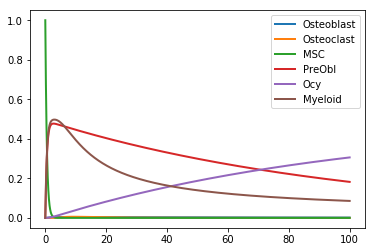

23


In [5]:
plt.interactive(False)
plt.plot(tspan, simulation_result.observables['Osteoblast_obs'], label = 'Osteoblast', lw=2)
plt.plot(tspan, simulation_result.observables['Osteoclast_obs'], label = 'Osteoclast', lw=2)
plt.plot(tspan, simulation_result.observables['Mesenchymal_SC_obs'], label = 'MSC', lw=2)
plt.plot(tspan, simulation_result.observables['PreOsteoblast_obs'], label = 'PreObl', lw=2)
plt.plot(tspan, simulation_result.observables['Osteocyte_obs'], label = 'Ocy', lw=2)
plt.plot(tspan, simulation_result.observables['Myeloid_obs'], label = 'Myeloid', lw=2)
#plt.plot(tspan, simulation_result.observables['RANKL_obs'], label = 'RANKL', lw=2)
plt.legend()
plt.show(block = True)

print(len(model.odes))

In [12]:
print(len(model.odes))
print(*model.odes, sep = "\n")

23
__s0*r3 + __s4*r3 + __s4*r4_kr + (__s0*r1)*(-1) + (__s0*r2)*(-1) + (__s0*__s2*r4_kf)*(-1)
__s1*r9 + (__s1*r15)*(-1) + (__s1*r16)*(-1) + (__s1*r17)*(-1)
__s4*r4_kr + __s7*r6_kr + (__s0*__s2*r4_kf)*(-1) + (__s2*__s8*r6_kf)*(-1)
__s0*r1 + __s4*r1
__s0*__s2*r4_kf + (__s4*r1)*(-1) + (__s4*r2)*(-1) + (__s4*r4_kr)*(-1) + (__s4*r5)*(-1)
__s1*r15 + __s11*r12_kr + (__s5*__s9*r12_kf)*(-1)
__s1*r16
__s2*__s8*r6_kf + __s4*r5 + (__s7*r6_kr)*(-1)
__s7*r6_kr + (__s8*r7)*(-1) + (__s15*__s8*r11)*(-1) + (__s2*__s8*r6_kf)*(-1)
__s11*r12_kr + __s7*r10 + (__s5*__s9*r12_kf)*(-1)
__s15*__s8*r11 + __s8*r7 + (__s10*r8)*(-1)
__s14*r13_kr + __s16*r13_kr + __s17*r13_kr + __s18*r13_kr + __s19*r13_kr + __s20*r13_kr + __s21*r13_kr + __s22*r13_kr + __s5*__s9*r12_kf + (__s11*r12_kr)*(-1) + (__s11**2*r13_kf)*(-2) + (__s13*r13_kr)*2 + (__s11*__s13*r13_kf)*(-1) + (__s11*__s14*r13_kf)*(-1) + (__s11*__s16*r13_kf)*(-1) + (__s11*__s17*r13_kf)*(-1) + (__s11*__s18*r13_kf)*(-1) + (__s11*__s19*r13_kf)*(-1) + (__s11*__s20*r13_k